## EMD Demo

[EnergyFlow website](https://energyflow.network)

In this tutorial, we demonstrate how to compute EMD values for particle physics events. The core of the computation is done using the [Python Optimal Transport](https://pot.readthedocs.io) library with EnergyFlow providing a convenient interface to particle physics events. Batching functionality is also provided using the builtin multiprocessing library to distribute computations to worker processes.

### Energy Mover's Distance

The Energy Mover's Distance was introduced in [1902.02346](https://arxiv.org/abs/1902.02346) as a metric between particle physics events. Closely related to the Earth Mover's Distance, the EMD solves an optimal transport problem between two distributions of energy (or transverse momentum), and the associated distance is the "work" required to transport supply to demand according to the resulting flow. Mathematically, we have
$$\text{EMD}(\mathcal E, \mathcal E') = \min_{\{f_{ij}\ge0\}}\sum_{ij} f_{ij} \frac{\theta_{ij}}{R} + \left|\sum_i E_i - \sum_j E'_j\right|,$$
$$\sum_{j} f_{ij} \le E_i,\,\,\, \sum_i f_{ij} \le E'_j,\,\,\,\sum_{ij}f_{ij}= \min\Big(\sum_iE_i,\,\sum_jE'_j\Big).$$

### Imports

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import energyflow as ef

### Plot Style

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

### Load EnergyFlow Quark/Gluon Jet Samples

In [3]:
# load quark and gluon jets
X, y = ef.qg_jets.load(2000, pad=False)
num = 750

# the jet radius for these jets
R = 0.4

# process jets
Gs, Qs = [], []
for arr,events in [(Gs, X[y==0]), (Qs, X[y==1])]:
    for i,x in enumerate(events):
        if i >= num:
            break

        # ignore padded particles and removed particle id information
        x = x[x[:,0] > 0,:3]

        # center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg

        # mask out any particles farther than R=0.4 away from center (rare)
        x = x[np.linalg.norm(x[:,1:3], axis=1) <= R]

        # add to list
        arr.append(x)

### Event Display with EMD Flow

In [67]:
import torch
from emd import earth_mover_distance
from energyflow.utils import p4s_from_ptyphims
from ot.lp import emd_c, check_result

# choose interesting events
ev0, ev1 = Gs[0][:50], Gs[1][:50]

# calculate the EMD and the optimal transport flow
R = 1
phi_col = 2
euclidean = True
periodic_phi = False
norm=True

pTs0, coords0 = ev0[:,0], ev0[:,1:]
pTs1, coords1 = ev1[:,0], ev1[:,1:]


if norm:
    pTs0 = pTs0/pTs0.sum()
    pTs1 = pTs1/pTs1.sum()
    
pT0, pT1 = pTs0.sum(), pTs1.sum()


pTdiff = pT1 - pT0
if pTdiff > 0:
    pTs0 = np.hstack((pTs0, pTdiff))
    coords0_extra = np.vstack((coords0, np.zeros(coords0.shape[1], dtype=np.float64)))
    thetas = ef.emd._cdist(coords0_extra, coords1, euclidean, periodic_phi, phi_col-1)/R
    thetas[-1,:] = 1.0
elif pTdiff < 0:
    pTs1 = np.hstack((pTs1, -pTdiff))
    coords1_extra = np.vstack((coords1, np.zeros(coords1.shape[1], dtype=np.float64)))
    thetas = ef.emd._cdist(coords0, coords1_extra, euclidean, periodic_phi, phi_col-1)/R
    thetas[:,-1] = 1.0
else:
    thetas = ef.emd._cdist(coords0, coords1, euclidean, periodic_phi, phi_col-1)/R
    
rescale = max(pT0, pT1)
G, cost, _, _, result_code = emd_c(pTs0/rescale, pTs1/rescale, thetas, 100000)
fullcalc = cost * rescale
G, cost, _, _, result_code = emd_c(np.ones_like(pTs0), np.ones_like(pTs1), thetas, 100000)
fullcalc = cost

print('full calculation:', fullcalc)
print(thetas.shape)
print(pTs0.shape)
print(pTs1.shape)

emdval = ef.emd.emd(ev0, ev1, R=R, phi_col=phi_col, measure='euclidean', periodic_phi=periodic_phi, norm=norm)
print('energy movers distance:', emdval)
#print(ev0)

p0 = np.zeros((coords0.shape[0],coords0.shape[1]+1))
p1 = np.zeros((coords1.shape[0],coords1.shape[1]+1))
p0[:,:-1] = coords0
p1[:,:-1] = coords1
p0 = torch.tensor(p0).to('cuda')
p1 = torch.tensor(p1).to('cuda')
#p0 = torch.tensor(p0*pTs0[...,np.newaxis]).to('cuda')
#p1 = torch.tensor(p1*pTs1[...,np.newaxis]).to('cuda')

print(p0.shape)
print(p1.shape)

#d = rescale*earth_mover_distance(p0/rescale, p1/rescale, transpose=False)
d = earth_mover_distance(p0, p1, transpose=False)
print(d)

full calculation: 84.67721816053128
(50, 50)
(50,)
(50,)
energy movers distance: 2.886268917657658
torch.Size([50, 3])
torch.Size([50, 3])
tensor([193.5519], device='cuda:0', dtype=torch.float64)


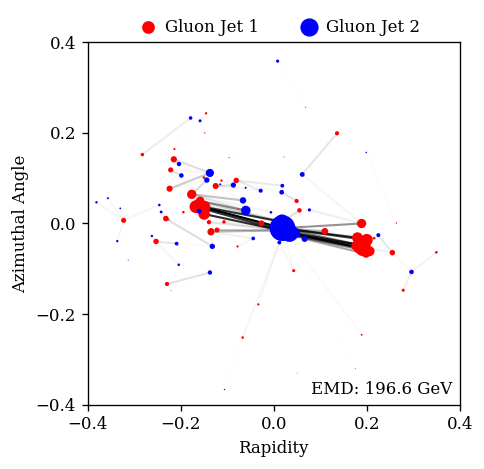

In [59]:
# calculate the EMD and the optimal transport flow
emdval, G = ef.emd.emd(ev0, ev1, R=R, return_flow=True,  phi_col=phi_col, measure='euclidean', periodic_phi=periodic_phi)

# plot the two events
colors = ['red', 'blue']
labels = ['Gluon Jet 1', 'Gluon Jet 2']
for i,ev in enumerate([ev0, ev1]):
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    plt.scatter(ys, phis, marker='o', s=2*pts, color=colors[i], lw=0, zorder=10, label=labels[i])
    
# plot the flow
mx = G.max()
xs, xt = ev0[:,1:3], ev1[:,1:3]
for i in range(xs.shape[0]):
    for j in range(xt.shape[0]):
        if G[i, j] > 0:
            plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                     alpha=G[i, j]/mx, lw=1.25, color='black')

# plot settings
plt.xlim(-R, R); plt.ylim(-R, R)
plt.xlabel('Rapidity'); plt.ylabel('Azimuthal Angle')
plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))

plt.text(0.6, 0.03, 'EMD: {:.1f} GeV'.format(emdval), fontsize=10, transform=plt.gca().transAxes)
plt.legend(loc=(0.1, 1.0), frameon=False, ncol=2, handletextpad=0)

plt.show()

### Intrinsic Dimension of Quark and Gluon Jets

The correlation dimension of a dataset is a type of fractal dimension which quantifies the dimensionality of the space of events at different energy scales $Q$.

It is motivated by the fact that the number of neighbors a point has in a ball of radius $Q$ grows as $Q^\mathrm{dim}$, giving rise to the definition:

$$ \dim (Q) = Q\frac{\partial}{\partial Q} \ln \sum_{i<j} \Theta(\mathrm{EMD}(\mathcal E_i, \mathcal E_j) < Q).$$

In [5]:
# compute pairwise EMDs between all jets (takes about 3 minutes, can change n_jobs if you have more cores)
g_emds = ef.emd.emds(Gs, R=R, norm=True, verbose=1, n_jobs=1, print_every=25000)
q_emds = ef.emd.emds(Qs, R=R, norm=True, verbose=1, n_jobs=1, print_every=25000)

Processed 750 events for symmetric EMD computation in 0.014s
  Computed 25000 EMDs, 8.90% done in 10.22s
  Computed 50000 EMDs, 17.80% done in 20.46s
  Computed 75000 EMDs, 26.70% done in 29.66s
  Computed 100000 EMDs, 35.60% done in 39.83s
  Computed 125000 EMDs, 44.50% done in 50.33s
  Computed 150000 EMDs, 53.40% done in 61.25s
  Computed 175000 EMDs, 62.31% done in 71.05s
  Computed 200000 EMDs, 71.21% done in 80.95s
  Computed 225000 EMDs, 80.11% done in 91.31s
  Computed 250000 EMDs, 89.01% done in 101.19s
  Computed 275000 EMDs, 97.91% done in 111.19s
Processed 750 events for symmetric EMD computation in 0.011s
  Computed 25000 EMDs, 8.90% done in 4.36s
  Computed 50000 EMDs, 17.80% done in 8.80s
  Computed 75000 EMDs, 26.70% done in 12.95s
  Computed 100000 EMDs, 35.60% done in 17.43s
  Computed 125000 EMDs, 44.50% done in 21.81s
  Computed 150000 EMDs, 53.40% done in 26.02s
  Computed 175000 EMDs, 62.31% done in 30.47s
  Computed 200000 EMDs, 71.21% done in 35.20s
  Computed 2

In [6]:
# prepare for histograms
bins = 10**np.linspace(-2, 0, 60)
reg = 10**-30
midbins = (bins[:-1] + bins[1:])/2
dmidbins = np.log(midbins[1:]) - np.log(midbins[:-1]) + reg
midbins2 = (midbins[:-1] + midbins[1:])/2

# compute the correlation dimensions
dims = []
for emd_vals in [q_emds, g_emds]:
    uemds = np.triu(emd_vals)
    counts = np.cumsum(np.histogram(uemds[uemds > 0], bins=bins)[0])
    dims.append((np.log(counts[1:] + reg) - np.log(counts[:-1] + reg))/dmidbins)

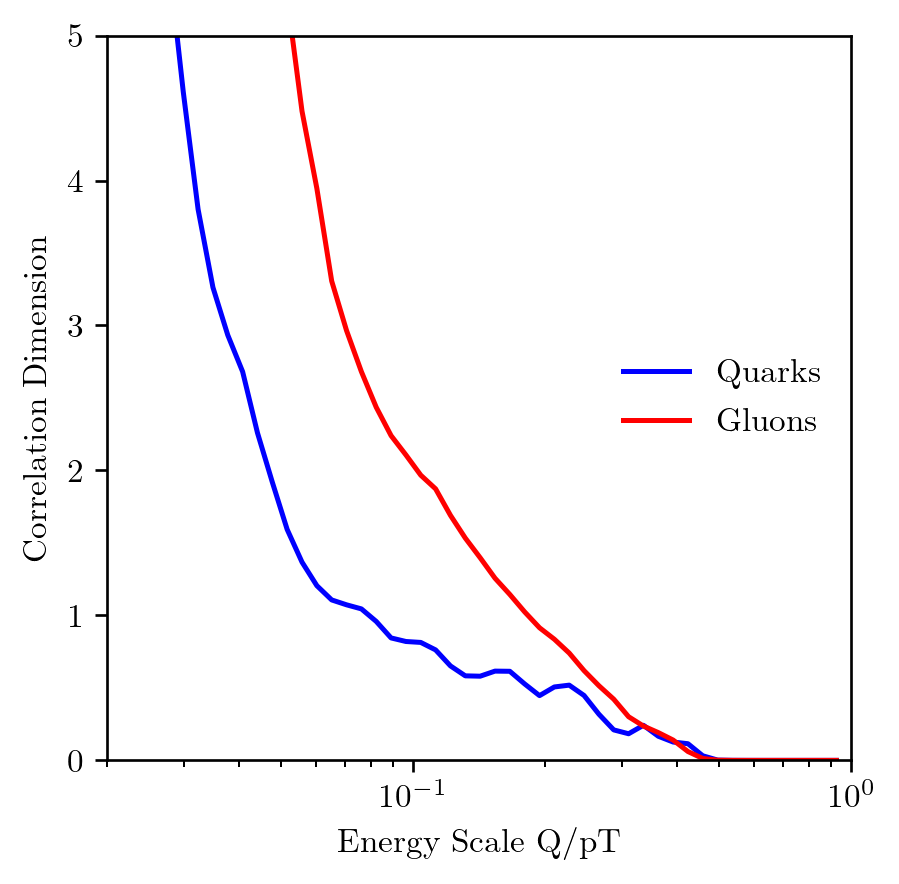

In [7]:
# plot the correlation dimensions
plt.plot(midbins2, dims[0], '-', color='blue', label='Quarks')
plt.plot(midbins2, dims[1], '-', color='red', label='Gluons')

# labels
plt.legend(loc='center right', frameon=False)

# plot style
plt.xscale('log')
plt.xlabel('Energy Scale Q/pT'); plt.ylabel('Correlation Dimension')
plt.xlim(0.02, 1); plt.ylim(0, 5)

plt.show()